# HSV Operator Example

This example demonstrates the use of HSV operator which manipulates the hue, saturation and value (brighness) aspects of the image.


## Introduction
### HSV Color Space
HSV represents colors by separating hue, saturation and brightness. In this color space, the hue is represented as an angle on the color circle. Saturation goes from 0 (greyscale) to 100% (fully saturated colors) and value goes from 0 (black) to 1 (full brightness). For details see:
[Wikipedia](https://en.wikipedia.org/wiki/HSL_and_HSV).

### A Note on Implementation
For performance reasons, DALI doesn't use the exact definition of HSV and approximates the operations in HSV space by linear (matrix) operations on RGB colors. This greatly improves performance at the cost of modest loss of fidelity.

## Step-by-Step Guide
1. Let's start from importing handful of utils and DALI itself.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types

batch_size = 10
image_filename = "../data/images"

Batch size is greater than one to facilitate switching between images at the end of the notebook.

2. Next, let's implement the pipelines. We've presented 2 versions of a pipeline. The CPU one does all the processing (i.e. reading file, decoding it and HSV manipulation) on the CPU, while the other pipeline conducts decoding and HSV manipulation on the GPU.

In [2]:
class HsvCpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super().__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.hsv = ops.Hsv(device="cpu", hue=120, saturation=1, value=0.4)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image)
        return image, converted
    
class HsvGpuPipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super().__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.hsv = ops.Hsv(device="gpu", hue=120, saturation=2, value=1)

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        converted = self.hsv(image.gpu())
        return image, converted

The function below is used to actually display result of HSV manipulation in DALI. Since the pipelines we set up return 2 outputs: modified image and original image, the function aquires both of them from the output and displays them. Additional flag (`cpu`) is specified, to determine, whether the pipeline output comes from CPU or GPU. In the latter case, we have to tell the output, to return a CPU-accessible copy of the data.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

def display(outputs, idx, columns=2, captions=None, cpu=True):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure()
    fig.set_size_inches(16, 6 * rows)
    gs = gridspec.GridSpec(rows, columns)
    row = 0
    col = 0
    for i, out in enumerate(outputs):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(out.at(idx) if cpu else out.as_cpu().at(idx))

3. Now let's just build the pipelines, run them and display the results. First the CPU one:

In [4]:
pipecpu = HsvCpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipecpu.build()          
cpu_output = pipecpu.run()

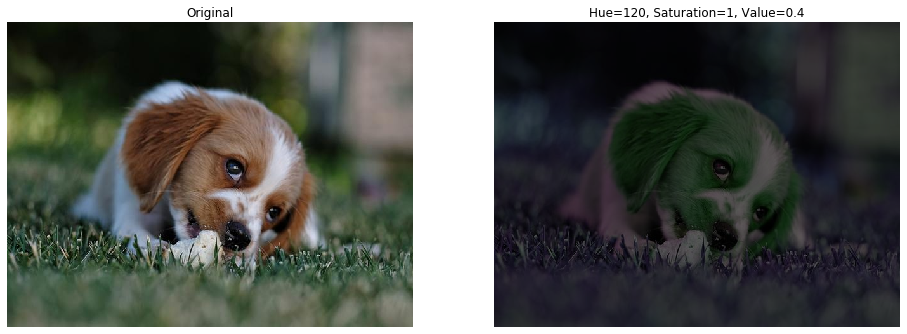

In [5]:
display(cpu_output, 3, captions=["Original", "Hue=120, Saturation=1, Value=0.4"])

4. And the GPU:

In [6]:
pipegpu = HsvGpuPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipegpu.build()          
gpu_output = pipegpu.run()

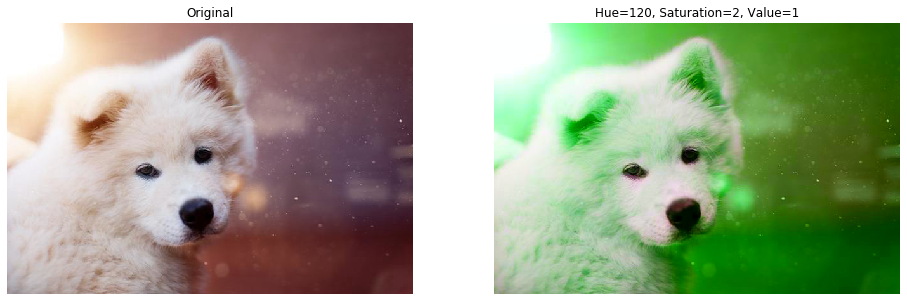

In [7]:
display(gpu_output, 0, cpu=False, captions=["Original", "Hue=120, Saturation=2, Value=1"])

# Using HSV to implement RandomGrayscale operator

As a more interesting example of Hsv Operator, we would like to implement something similar to Pytorch's RandomGrayscale transformation - for a RGB input either convert it to grayscale image that still consists 3 channels (but with equal values) or pass it through unchanged.

To achieve the grayscale conversion, we will desaturate the input (set `saturation` to 0 for those samples). If we set the `saturation` to 1, the image will keep its colors. 

We can use CoinFlip oprator, that returns 0s and 1s with configurable probability. We will use the values generated by CoinFlip to drive the `saturate` parameter of Hsv operator. 

CoinFlip generates a number for every sample in the processed batch and we pass them in the `define_graph` step instead of specifying single scaler value in Hsv constructor. Because CoinFlip returns integers, and Hsv expects floats as its parameters, we also need to convert those values using Cast Operator.

In [8]:
class RandomGrayscalePipeline(Pipeline):                   
    def __init__(self, batch_size, num_threads, device_id):
        super().__init__(batch_size, num_threads, device_id, seed=42)
        self.input = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="mixed", output_type=types.RGB)
        self.coin = ops.random.CoinFlip(probability=0.7)
        self.cast_fp32 = ops.Cast(dtype=types.FLOAT)
        self.hsv = ops.Hsv(device="gpu")

    def define_graph(self):                                                                
        read, _ = self.input()
        image = self.decode(read)
        saturate = self.coin()
        saturate_fp32 = self.cast_fp32(saturate)
        converted = self.hsv(image, saturation=saturate_fp32)
        return image, converted

Let's now build and run the pipeline.

In [9]:
pipe = RandomGrayscalePipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()          
output = pipe.run()

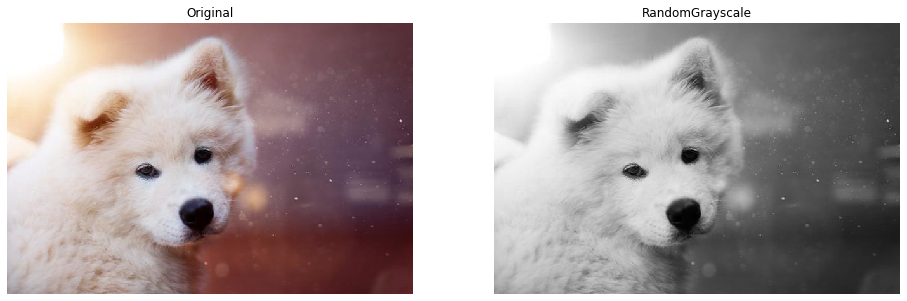

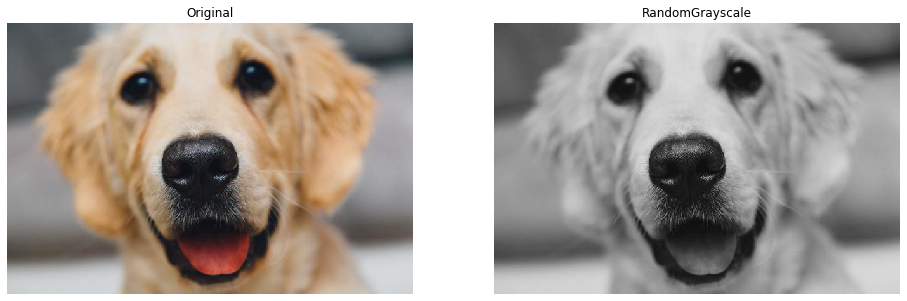

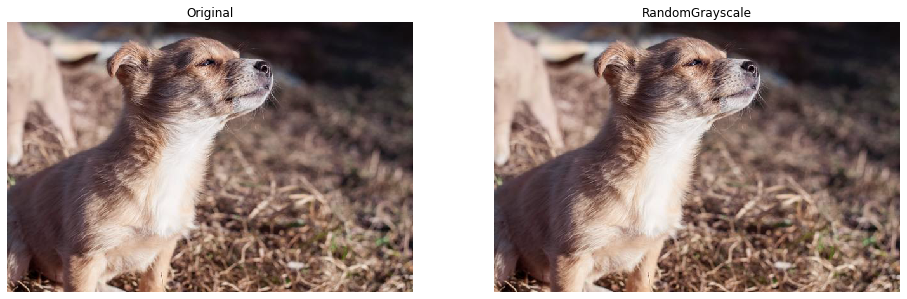

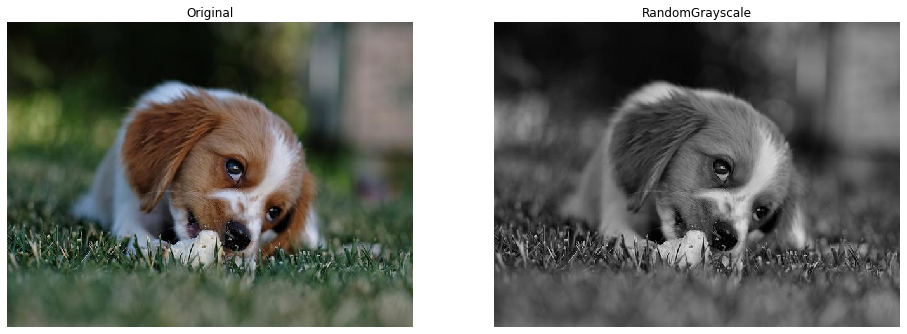

In [10]:
display(output, 0, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 1, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 2, cpu=False, captions=["Original", "RandomGrayscale"])
display(output, 3, cpu=False, captions=["Original", "RandomGrayscale"])

## Using Functional API

We can leverage DALI functional API to achive the same result using terser syntax. For more details see DALI docs under `Python API` > `Functional API`.

Let's import necessary headers.

In [11]:
import nvidia.dali.fn as fn

We can define our `random_grayscale` as easy to use function. The functional API will pick the device for the `fn.hsv` Operator based on the backend of the input data.

In [12]:
def random_grayscale(input, prob):
    saturate = fn.random.coin_flip(probability=prob)
    saturate_fp32 = fn.cast(saturate, dtype=types.FLOAT)
    return fn.hsv(input, saturation=saturate_fp32)

Now we can implement our pipeline without subclassing the Pipeline or instantiating the Operators.

Here we can see example of explicitely specifying `device` argument for `image_decoder`. All following operators from functional API that will accept the `images`, which is returned as GPU data, will be inferred to use `GPU` backend. Hence the hsv calculation in `random_grayscale` will be done on GPU.

In [13]:
pipe = Pipeline(batch_size=batch_size, num_threads=1, device_id=0, seed=42)
with pipe:
    files, _ = fn.file_reader(file_root=image_filename)
    images = fn.image_decoder(files, device="mixed")
    converted = random_grayscale(images, 0.7)
    pipe.set_outputs(images, converted)

Let's build and run the pipeline to see the results. Since we use the same `seed` value, the output should match the one we've got before.

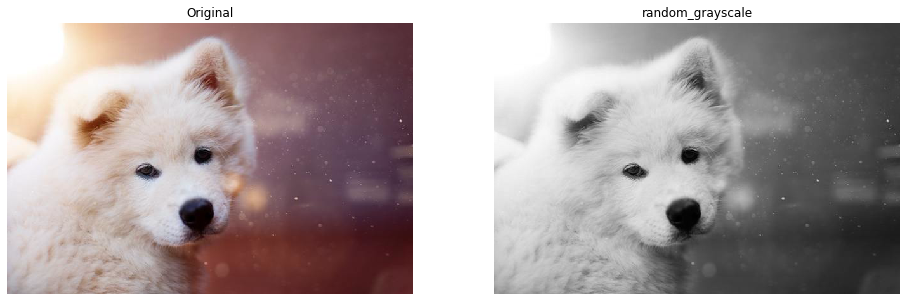

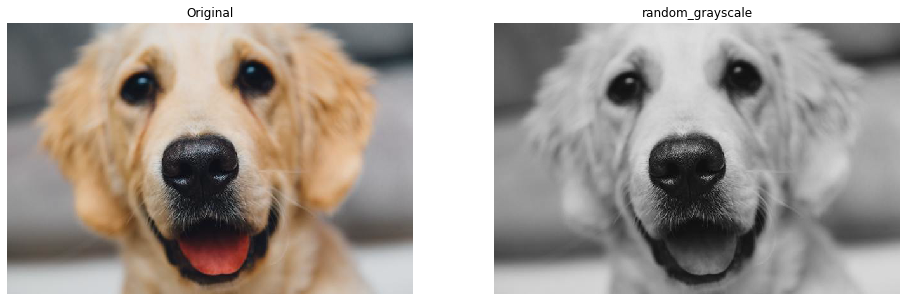

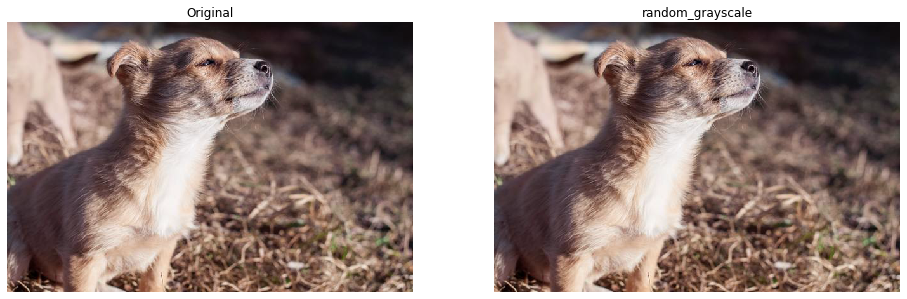

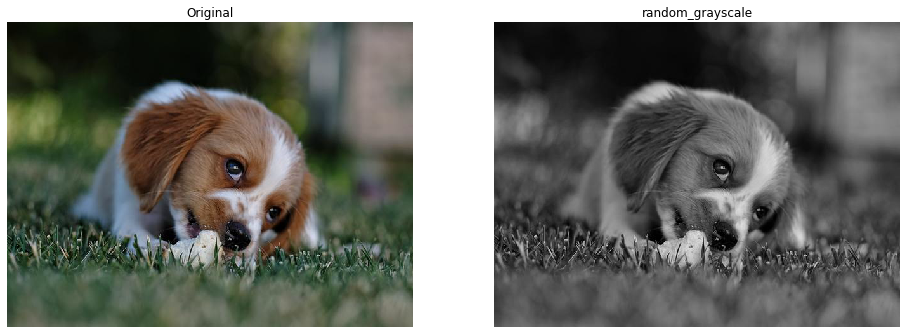

In [14]:
pipe.build()
output = pipe.run()

display(output, 0, cpu=False, captions=["Original", "random_grayscale"])
display(output, 1, cpu=False, captions=["Original", "random_grayscale"])
display(output, 2, cpu=False, captions=["Original", "random_grayscale"])
display(output, 3, cpu=False, captions=["Original", "random_grayscale"])